# Swish Analytics Tennis Ace Analysis


## Assignemnt 
Attached here is a link to zip containing 2 data files containing all points played from the 2017 ATP season and the associated player information.

Please review the dataset and start outlining the way you would go about the model-building process with the goal of predicting the probability that the next serve will be an ace.

We would like to see you:
- Assess the data
- Build a predictive model
- Evaluate that model and the quality of its predictions

Other Notes:

Delivering predictions with exceptional lack of error is unlikely in this short time span. Please provide any associated data analysis (plots, graphs, etc..), feature engineering, and code assembled in the form of a python notebook. Please include markup text to explain your analysis, graphs, etc. If you include a notebook, please also add an HTML version of that notebook, to facilitate review.

# Summary

In this analysis I clean and transform the raw player and match data. Next, I explore the different features which could have an impact on the ace probability ie player height, game situation, or previous point outcomes. Once I had a good sense of the data I created a data pipeline to handle further data transformations for numeric and categorical data and used that pipeline to fit and assess 4 different models using classification metrics useful for problems with imbalanced data. Of the 4 models the HistGradientBoosting Classifier performed the best with and **AUC ROC score of 0.67**. Finally, once this model was chosen I took the model fitted on the training data and evaluated it on the hold out set where it achieved a similar score of **0.66**, indicating the overfitting was not an issue.

## Outline of Analysis

1. **EDA**
    - What variables would I assume are important before looking at the data?
    - What is the base rate for Aces?
3. **Problem Statement**
    - Predict if the next serve is an ace
    - Looking into the future undermines the reason for solving the problem in the first place so no full match or future point data allowed
4. **Basic Feature Engineering**
    - Each row of data should be set up with the server and reciever palyer information combined with match data and target variable (Ace or no ace)
6. **Guiding Success Metrics**
    - Not accuracy
    - Classification metrics which handle imbalanced data well (f1, auc_roc, precision, recall)
12. **Feature Engineering**
    - Previous point outcomes
10. **Model choices**
    - Histogram Gradient Boosting Trees
    - Random Forest
    - Logistic Regression
    - KNN
13. **Model Interpretability**
    - Linear models: Coefficients
    - Tree based: Information Gain
14. **Appendix**
    - Calibration of probabilities
    - Threshold optimization
16. **Future Work**
    - SHAP Values
    - More feature engineering: Surface used at tournement, Previous years data, cummulative player stats


In [1]:
import polars as pl
import polars.selectors as cs
pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000)

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import os

# Create Holdout Set for Testing

Create the hold out set separated by match id not indivdual row since we don't want to leak any data about the previous points played into the training set

Test set will only be used to estimate the final model performance.

Ideally the next years data would be the best test set since it would cover all of the tournements and surfaces again but since this is restricted to this years data a more simple match based random split will be sufficient

Converting the data files to parquet makes the space requirement much lower and accessing the data much more efficient

In [2]:
if os.path.exists('../data/tennis_players.csv'):
    print('Tennis player data already converted to parquet')
    
else:
    players = pl.read_csv(
        '../data/tennis_players.csv',
    )
    players.write_parquet('../data/tennis_players.parquet')

Tennis player data already converted to parquet


In [3]:
if os.path.exists('../data/train_matches.parquet') and os.path.exists('../data/test_matches.parquet'):
    print(f"Train and test split files already exist.")
else:
    matches = pl.read_csv('../data/tennis_project.csv')
    
    match_ids = matches['match_id'].unique()
    
    split_ratio = .8
    
    num_matches = len(match_ids)
    
    split_idx = int(split_ratio*num_matches)
    
    shuffled_matches = match_ids.shuffle(seed=24)
    train_ids, test_ids = pl.DataFrame(shuffled_matches[:split_idx]), pl.DataFrame(shuffled_matches[split_idx:])
    
    train_matches = matches.join(train_ids, on='match_id')
    
    train_matches.write_parquet('../data/train_matches.parquet')
    
    test_matches = matches.join(test_ids, on='match_id')
    
    test_matches.write_parquet('../data/test_matches.parquet')

Train and test split files already exist.


# Data Cleaning and Transformations

Identify which columns from the players and matches tables would be usable.

The model needs to predict if the next serve will be an Ace so any columns which contain information from before the serve must not be used. If the question was more broadly about which features of players and matches led to more Aces then we could use future data but for a real time Ace predicting model this information is out of bounds.

Example columns which contain future information:
- match score
- match time
- point outcomes ie double fault or ralley length (These columns could be useful as predictors for the next point but not the current row)


Before looking at the data just using current tennis knowledge what columns could be useful?
- **Height**: Many of the big servers on the ATP are extreamly tall which gives them a better hitting angle and generally more powerful. [Height and serve speed correlational research](https://www.researchgate.net/publication/237000899_Association_between_body_height_and_serve_speed_in_elite_tennis_players)
- **Strong Hand**: The pairing of opposite handed players could lead to a higher Ace percentage. Lefty servers are comparitively less common so players can find it harder to adjust to the opposite spin of the more common right handed players. Check out this [article](https://www.researchgate.net/publication/233662793_The_Serve_in_Professional_Men%27s_Tennis_Effects_of_Players%27_Handedness) quantifying the differences in ball path and spin between right and left handed servers.
- **Backhand type**: A two handed backhand tends to be more reliable when it comes to returning difficult serves
- **Game/set/match Situations**:
    - A player may be able to adapt to a difficult serve as the match goes on for longer reducing Ace %
    - A player may get more or less aggressive with their serve at different points in the game
- **Surface**: Different court surface have different speeds where balls bounce lower and faster compared to other surfaces which is backed up by [research](https://doi.org/10.1080/24748668.2018.1467995) involving serve speed. Grass is known to be the fastest, making the strategy for riskier flat serves more rewarding while clay being the slowest surface tends to discourage big flat serves with little spin. Since there is no direct surface feature available a good proxy is the tournament name and time of year since there is regularity on when particular surfaces are played. 


## Player Data

In [4]:
players = pl.read_parquet(
    '../data/tennis_players.parquet',
    columns=[
        'name',
        'year_turned_pro',
        'height_cm',
        'weight_kg',
        'strong_hand',
        'backhand_type'
    ]
)
players.head()

name,year_turned_pro,height_cm,weight_kg,strong_hand,backhand_type
str,i64,i64,i64,str,str
"""Ronald Agenor""",1983,180,82,"""Right-Handed""","""Unknown Backhand"""
"""Marc Albert""",null,null,null,"""Right-Handed""","""Unknown Backhand"""
"""Marcos Vinicius Azevedo Silva""",null,null,null,"""Right-Handed""","""Unknown Backhand"""
"""Andre Agassi""",1986,180,80,"""Right-Handed""","""Two-Handed Backhand"""
"""Alafia Ayeni""",null,191,84,"""Right-Handed""","""Two-Handed Backhand"""


In [5]:
players.describe()

statistic,name,year_turned_pro,height_cm,weight_kg,strong_hand,backhand_type
str,str,f64,f64,f64,str,str
"""count""","""10982""",1400.0,3528.0,3652.0,"""5617""","""5617"""
"""null_count""","""0""",9582.0,7454.0,7330.0,"""5365""","""5365"""
"""mean""",null,2003.075,183.95805,78.407448,null,null
"""std""",null,9.232798,6.957602,8.080459,null,null
"""min""","""A.J. Catanzariti""",1933.0,132.0,49.0,"""Ambidextrous""","""One-Handed Backhand"""
"""25%""",null,1996.0,180.0,73.0,null,null
"""50%""",null,2002.0,183.0,78.0,null,null
"""75%""",null,2010.0,188.0,83.0,null,null
"""max""","""Zvonimir Oreskovic""",2023.0,244.0,197.0,"""Right-Handed""","""Unknown Backhand"""


### Missing Values

There appears to a sizable amount of null values for the player data

We can impute these missing values and add a constant showing that there is a missing value.

For Categorical nulls we can add a 'missing' string to indicate the info is not available

For Numeric columns we can impute the mean then add an indicator column to show when a value has been imputed. Models can use this information to improve predictions



## Match Data

In [6]:
feature_cols = [
    'points_1',
    'points_2',
    'games_1',
    'games_2',
    'sets_1',
    'sets_2',
    'point_number',
    'server',
    'ace',
    'double_fault',
    'match_id',
    'tournament',
    'player1',
    'player2',
    'date'
]


train_matches = pl.read_parquet('../data/train_matches.parquet', columns=feature_cols)
train_matches.head()

points_1,points_2,games_1,games_2,sets_1,sets_2,point_number,server,ace,double_fault,match_id,tournament,player1,player2,date
i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,str,str,str,str
0,0,0,0,0,0,1,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""Elias Ymer""","""Jordan Thompson""","""01 Jan 17"""
15,0,0,0,0,0,2,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""Elias Ymer""","""Jordan Thompson""","""01 Jan 17"""
30,0,0,0,0,0,3,"""Elias Ymer""",0,1,1,"""ATPBrisbane-BrisbaneInternational""","""Elias Ymer""","""Jordan Thompson""","""01 Jan 17"""
30,15,0,0,0,0,4,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""Elias Ymer""","""Jordan Thompson""","""01 Jan 17"""
40,15,0,0,0,0,5,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""Elias Ymer""","""Jordan Thompson""","""01 Jan 17"""


In [7]:
train_matches.describe()

statistic,points_1,points_2,games_1,games_2,sets_1,sets_2,point_number,server,ace,double_fault,match_id,tournament,player1,player2,date
str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,str,str,str
"""count""",281955.0,281955.0,281955.0,281955.0,281955.0,281955.0,281955.0,"""281955""",281955.0,281955.0,281955.0,"""281955""","""281955""","""281955""","""281955"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,"""0""","""0""","""0""","""0"""
"""mean""",19.13849,19.00903,2.421223,2.328634,0.491217,0.450678,92.490213,null,0.071511,0.036673,1091.05658,null,null,null,null
"""std""",16.340661,16.354855,1.817875,1.818187,0.636105,0.599584,64.623463,null,0.257678,0.187957,632.594543,null,null,null,null
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,"""Adam Pavlasek""",0.0,0.0,1.0,"""ATPAcapulco-AbiertoMexicanoTelcel""","""Adam Pavlasek""","""Adam Pavlasek""","""01 Aug 17"""
"""25%""",0.0,0.0,1.0,1.0,0.0,0.0,42.0,null,0.0,0.0,525.0,null,null,null,null
"""50%""",15.0,15.0,2.0,2.0,0.0,0.0,83.0,null,0.0,0.0,1120.0,null,null,null,null
"""75%""",30.0,30.0,4.0,4.0,1.0,1.0,131.0,null,0.0,0.0,1625.0,null,null,null,null
"""max""",50.0,50.0,21.0,20.0,4.0,3.0,450.0,"""Zhe Li""",1.0,1.0,2147.0,"""Men'sUSOpen""","""Zhe Li""","""Yuki Bhambri""","""31 May 17"""


## Join match and player data

Join on name to add player data as server and returner columns

In [8]:
train_matches = (train_matches.with_columns(
                     pl.when(pl.col('server') == pl.col('player1'))
                     .then(pl.col('player2'))
                     .otherwise(pl.col('player1'))
                     .alias('returner')
                 ).join(
                     players.select(pl.all().name.suffix("_server")),
                     how='left',
                     left_on='server',
                     right_on='name_server',
                 ).join(
                     players.select(pl.all().name.suffix("_returner")),
                     how='left',
                     left_on='returner',
                     right_on='name_returner',
                 ))

### Add Score Features


In [9]:
def create_score_features(X, column):
    X = X.with_columns(
        pl.when(pl.col('server') == pl.col('player1'))
        .then(pl.col(f'{column}_1'))
        .otherwise(pl.col(f'{column}_2'))
        .alias(f'{column}_server')
    )

    X = X.with_columns(
        pl.when(pl.col('server') == pl.col('player1'))
        .then(pl.col(f'{column}_2'))
        .otherwise(pl.col(f'{column}_1'))
        .alias(f'{column}_returner')
    )

    return X

for col in ['points', 'games', 'sets']:
    train_matches = create_score_features(train_matches, col)

train_matches = train_matches.drop([
    'points_1',
    'points_2',
    'games_1',
    'games_2',
    'sets_1',
    'sets_2',
    'player1',
    'player2'
])

train_matches

point_number,server,ace,double_fault,match_id,tournament,date,returner,year_turned_pro_server,height_cm_server,weight_kg_server,strong_hand_server,backhand_type_server,year_turned_pro_returner,height_cm_returner,weight_kg_returner,strong_hand_returner,backhand_type_returner,points_server,points_returner,games_server,games_returner,sets_server,sets_returner
i64,str,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64
1,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",0,0,0,0,0,0
2,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",15,0,0,0,0,0
3,"""Elias Ymer""",0,1,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,0,0,0,0,0
4,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,15,0,0,0,0
5,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",40,15,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
188,"""Tomas Berdych""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Ryan Harrison""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",3,3,6,6,2,0
189,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,4,6,6,0,2
190,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,5,6,6,0,2


### Add previous point info

In [10]:
train_matches = train_matches.select(
    pl.all(),
    pl.col('ace').sort_by('point_number').shift(fill_value=0).over('match_id', 'server').alias('prev_ace'),
    pl.col('double_fault').sort_by('point_number').shift(fill_value=0).over('match_id', 'server').alias('prev_double_fault')
)

train_matches

point_number,server,ace,double_fault,match_id,tournament,date,returner,year_turned_pro_server,height_cm_server,weight_kg_server,strong_hand_server,backhand_type_server,year_turned_pro_returner,height_cm_returner,weight_kg_returner,strong_hand_returner,backhand_type_returner,points_server,points_returner,games_server,games_returner,sets_server,sets_returner,prev_ace,prev_double_fault
i64,str,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64
1,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",0,0,0,0,0,0,0,0
2,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",15,0,0,0,0,0,0,0
3,"""Elias Ymer""",0,1,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,0,0,0,0,0,0,0
4,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,15,0,0,0,0,0,1
5,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",40,15,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
188,"""Tomas Berdych""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Ryan Harrison""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",3,3,6,6,2,0,0,0
189,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,4,6,6,0,2,0,0
190,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,5,6,6,0,2,0,0


In [11]:
train_matches = train_matches.with_columns(
    pl.col('date').str.to_date(format='%d %b %y').alias('datetime')
)

train_matches

point_number,server,ace,double_fault,match_id,tournament,date,returner,year_turned_pro_server,height_cm_server,weight_kg_server,strong_hand_server,backhand_type_server,year_turned_pro_returner,height_cm_returner,weight_kg_returner,strong_hand_returner,backhand_type_returner,points_server,points_returner,games_server,games_returner,sets_server,sets_returner,prev_ace,prev_double_fault,datetime
i64,str,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,date
1,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",0,0,0,0,0,0,0,0,2017-01-01
2,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",15,0,0,0,0,0,0,0,2017-01-01
3,"""Elias Ymer""",0,1,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,0,0,0,0,0,0,0,2017-01-01
4,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,15,0,0,0,0,0,1,2017-01-01
5,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",40,15,0,0,0,0,0,0,2017-01-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
188,"""Tomas Berdych""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Ryan Harrison""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",3,3,6,6,2,0,0,0,2017-08-30
189,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,4,6,6,0,2,0,0,2017-08-30
190,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,5,6,6,0,2,0,0,2017-08-30


### Cummulative Ace counts and Ace Percentage

In [12]:
train_matches = train_matches.sort(by=['match_id', 'point_number']).select(
    pl.all(),
    pl.col('ace').shift(fill_value=0).cum_sum().over('server').alias('current_aces'),
    pl.col('ace').shift(fill_value=0).cum_count().over('server').alias('current_serves'),
    (pl.col('ace').shift(fill_value=0).cum_sum().over('server') / pl.col('ace').shift(fill_value=0).cum_count().over('server')).alias('current_ace_pct'),
)

train_matches

point_number,server,ace,double_fault,match_id,tournament,date,returner,year_turned_pro_server,height_cm_server,weight_kg_server,strong_hand_server,backhand_type_server,year_turned_pro_returner,height_cm_returner,weight_kg_returner,strong_hand_returner,backhand_type_returner,points_server,points_returner,games_server,games_returner,sets_server,sets_returner,prev_ace,prev_double_fault,datetime,current_aces,current_serves,current_ace_pct
i64,str,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,date,i64,u32,f64
1,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",0,0,0,0,0,0,0,0,2017-01-01,0,1,0.0
2,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",15,0,0,0,0,0,0,0,2017-01-01,0,2,0.0
3,"""Elias Ymer""",0,1,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,0,0,0,0,0,0,0,2017-01-01,0,3,0.0
4,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,15,0,0,0,0,0,1,2017-01-01,0,4,0.0
5,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",40,15,0,0,0,0,0,0,2017-01-01,0,5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
188,"""Tomas Berdych""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Ryan Harrison""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",3,3,6,6,2,0,0,0,2017-08-30,294,3159,0.093067
189,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,4,6,6,0,2,0,0,2017-08-30,190,1917,0.099113
190,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,5,6,6,0,2,0,0,2017-08-30,190,1918,0.099062


### Tie Break Points

Most of the points are in the format 0, 15, 30, and 40. As well as 50 to indicate advantage after deuce.

There is a small subset of points the are single digits up to 6. This indicates that the players went to tie breaks becuase the were tied in games 6-6 at the end of a set. The winner of a tie break is the first to 7 points.

Consider adding an indicator variable for tie breaks. Not totally necessary since the games count will always be 6-6 when moving to the tie break format

In [13]:
train_matches.filter(
    (pl.col('points_server') < 15 ) & 
    (pl.col('points_server') != 0)
).head()

point_number,server,ace,double_fault,match_id,tournament,date,returner,year_turned_pro_server,height_cm_server,weight_kg_server,strong_hand_server,backhand_type_server,year_turned_pro_returner,height_cm_returner,weight_kg_returner,strong_hand_returner,backhand_type_returner,points_server,points_returner,games_server,games_returner,sets_server,sets_returner,prev_ace,prev_double_fault,datetime,current_aces,current_serves,current_ace_pct
i64,str,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,date,i64,u32,f64
102,"""Kyle Edmund""",0,0,4,"""ATPBrisbane-BrisbaneInternational""","""02 Jan 17""","""Ernesto Escobedo""",2012,188,83,"""Right-Handed""","""Two-Handed Backhand""",2014,185,82,"""Right-Handed""","""Two-Handed Backhand""",3,0,6,6,0,0,0,0,2017-01-02,5,42,0.119048
103,"""Kyle Edmund""",0,0,4,"""ATPBrisbane-BrisbaneInternational""","""02 Jan 17""","""Ernesto Escobedo""",2012,188,83,"""Right-Handed""","""Two-Handed Backhand""",2014,185,82,"""Right-Handed""","""Two-Handed Backhand""",4,0,6,6,0,0,0,0,2017-01-02,5,43,0.116279
104,"""Ernesto Escobedo""",0,0,4,"""ATPBrisbane-BrisbaneInternational""","""02 Jan 17""","""Kyle Edmund""",2014,185,82,"""Right-Handed""","""Two-Handed Backhand""",2012,188,83,"""Right-Handed""","""Two-Handed Backhand""",1,4,6,6,0,0,0,0,2017-01-02,3,61,0.04918
105,"""Ernesto Escobedo""",0,0,4,"""ATPBrisbane-BrisbaneInternational""","""02 Jan 17""","""Kyle Edmund""",2014,185,82,"""Right-Handed""","""Two-Handed Backhand""",2012,188,83,"""Right-Handed""","""Two-Handed Backhand""",2,4,6,6,0,0,0,0,2017-01-02,3,62,0.048387
106,"""Kyle Edmund""",0,0,4,"""ATPBrisbane-BrisbaneInternational""","""02 Jan 17""","""Ernesto Escobedo""",2012,188,83,"""Right-Handed""","""Two-Handed Backhand""",2014,185,82,"""Right-Handed""","""Two-Handed Backhand""",4,3,6,6,0,0,0,0,2017-01-02,5,44,0.113636


# Exploritory Data Analysis

## Single Match Analysis

Before jumping into the modeling phase, lets understand the shape of the data. Specifically, how is the progression of a match encoded.

Here we will take a look at a match between John Isner and Yoshihito Nishioka at the Memphis Open where Isner wins 4-6, 6-3 and 6-4 in 104 minutes.

In [14]:
isner_nishioka_match = train_matches.filter(pl.col('match_id') == 285)

isner_nishioka_match.head(10)

point_number,server,ace,double_fault,match_id,tournament,date,returner,year_turned_pro_server,height_cm_server,weight_kg_server,strong_hand_server,backhand_type_server,year_turned_pro_returner,height_cm_returner,weight_kg_returner,strong_hand_returner,backhand_type_returner,points_server,points_returner,games_server,games_returner,sets_server,sets_returner,prev_ace,prev_double_fault,datetime,current_aces,current_serves,current_ace_pct
i64,str,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,date,i64,u32,f64
1,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",0,0,0,0,0,0,0,0,2017-02-16,53,404,0.131188
2,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",15,0,0,0,0,0,0,0,2017-02-16,53,405,0.130864
3,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",15,15,0,0,0,0,0,0,2017-02-16,53,406,0.130542
4,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",15,30,0,0,0,0,0,0,2017-02-16,53,407,0.130221
5,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",15,40,0,0,0,0,0,0,2017-02-16,53,408,0.129902
6,"""John Isner""",1,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",30,40,0,0,0,0,0,0,2017-02-16,53,409,0.129584
7,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",40,40,0,0,0,0,1,0,2017-02-16,54,410,0.131707
8,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",50,40,0,0,0,0,0,0,2017-02-16,54,411,0.131387
9,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",40,40,0,0,0,0,0,0,2017-02-16,54,412,0.131068


### Ace Differential

John Isner is known to be one of the best servers of this era standing at about 6 foot 7 inches tall so it is unsuprising that he holds an ace advantage over Nishioka who is over a foot shorter and is not known for his serving. The ace differential in this game is 24 to 1 in favor is Isner who aced Nishioka in just under a third of all points!

In [15]:
(
    isner_nishioka_match
    .group_by('server')
    .agg(
        pl.len().alias('serves'),
        pl.col('ace').sum().alias('aces'),
        pl.col('ace').mean().round(2).alias('ace_pct')
    )
    .sort('server')
)

server,serves,aces,ace_pct
str,u32,i64,f64
"""John Isner""",80,24,0.3
"""Yoshihito Nishioka""",90,1,0.01


### Aces by Game Points

Are there any big differences in when Aces are occuring based on game situation?

This match is somewhat of an outlier since Nishioka only had 1 ace so drawing conclusions from just this match could be misleading. Lets leave out a deeper analysis of Nishioka's service game and focus on Isner.

Isner has 24 aces spread over the match so his ace distribution can give us more information about his serving tendencies.

The top 10 game score situations in which Isner scored an Ace are when he has a lead in the game. The top 2 situations he scored the most aces are when he is up 15-0 and 30-0. The next most common situation is when the score is love all (0-0) since this is the most common points situation. 

The takeaway from Isner's game is that he tends to go for and be successful at acing his opponent when he is already up in the game and is willing to go for a higher risk serve.

We will see if this trend in strategy which is fairly common in the tennis world holds up in a wider sample of data

In [16]:
isner_nishioka_match.head()

point_number,server,ace,double_fault,match_id,tournament,date,returner,year_turned_pro_server,height_cm_server,weight_kg_server,strong_hand_server,backhand_type_server,year_turned_pro_returner,height_cm_returner,weight_kg_returner,strong_hand_returner,backhand_type_returner,points_server,points_returner,games_server,games_returner,sets_server,sets_returner,prev_ace,prev_double_fault,datetime,current_aces,current_serves,current_ace_pct
i64,str,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,date,i64,u32,f64
1,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",0,0,0,0,0,0,0,0,2017-02-16,53,404,0.131188
2,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",15,0,0,0,0,0,0,0,2017-02-16,53,405,0.130864
3,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",15,15,0,0,0,0,0,0,2017-02-16,53,406,0.130542
4,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",15,30,0,0,0,0,0,0,2017-02-16,53,407,0.130221
5,"""John Isner""",0,0,285,"""ATPMemphis-MemphisOpen""","""16 Feb 17""","""Yoshihito Nishioka""",2007,208,108,"""Right-Handed""","""Two-Handed Backhand""",2014,170,64,"""Left-Handed""","""Two-Handed Backhand""",15,40,0,0,0,0,0,0,2017-02-16,53,408,0.129902


In [17]:
(
    isner_nishioka_match
    .group_by('server', 'points_server', 'points_returner')
    .agg(
        pl.len().alias('serves'),
        pl.col('ace').sum().alias('aces'),
        pl.col('ace').mean().round(2).alias('ace_pct')
    )
    .filter(pl.col('server') == "John Isner")
    .sort('aces', descending=True)
).head(10)

server,points_server,points_returner,serves,aces,ace_pct
str,i64,i64,u32,i64,f64
"""John Isner""",15,0,9,4,0.44
"""John Isner""",30,0,8,4,0.5
"""John Isner""",0,0,15,3,0.2
"""John Isner""",30,15,6,2,0.33
"""John Isner""",40,15,5,2,0.4
"""John Isner""",40,0,6,2,0.33
"""John Isner""",30,30,3,2,0.67
"""John Isner""",40,30,3,1,0.33
"""John Isner""",15,15,6,1,0.17


In [18]:
(
    isner_nishioka_match
    .group_by('server', 'games_server', 'games_returner')
    .agg(
        pl.len().alias('serves'),
        pl.col('ace').sum().alias('aces'),
        pl.col('ace').mean().round(2).alias('ace_pct')
    )
    .filter(pl.col('server') == "John Isner")
    .sort('aces', descending=True)
).head(10)

server,games_server,games_returner,serves,aces,ace_pct
str,i64,i64,u32,i64,f64
"""John Isner""",0,0,15,3,0.2
"""John Isner""",5,3,4,3,0.75
"""John Isner""",3,1,4,3,0.75
"""John Isner""",2,0,6,2,0.33
"""John Isner""",4,3,4,2,0.5
"""John Isner""",2,3,6,2,0.33
"""John Isner""",5,4,4,2,0.5
"""John Isner""",1,2,5,2,0.4
"""John Isner""",0,1,6,1,0.17


In [19]:
cummulative_aces_isner_nishioka = (
    isner_nishioka_match
    .select(
        pl.col('server'),
        pl.col('point_number'),
        pl.cum_sum('ace').over(pl.col('server')).alias('cummulative aces')
    )
)

cummulative_aces_isner_nishioka

server,point_number,cummulative aces
str,i64,i64
"""John Isner""",1,0
"""John Isner""",2,0
"""John Isner""",3,0
"""John Isner""",4,0
"""John Isner""",5,0
…,…,…
"""Yoshihito Nishioka""",166,1
"""John Isner""",167,22
"""John Isner""",168,23


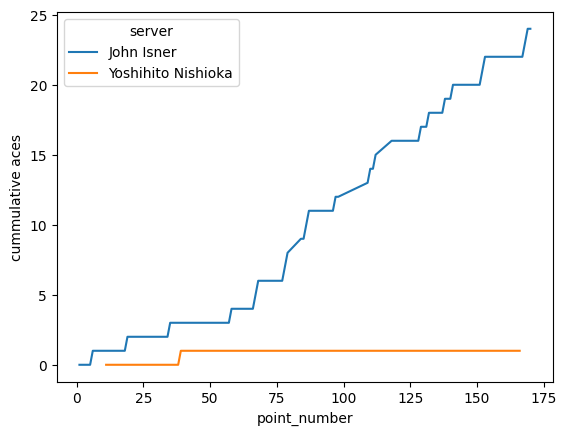

In [20]:
sns.lineplot(cummulative_aces_isner_nishioka, x='point_number', y='cummulative aces', hue='server');

## Full Ace Analysis

How does Ace percentage change with different groupings of data?

In [21]:
print(f"Overall Ace Percentage: {train_matches['ace'].mean():.2%}")

Overall Ace Percentage: 7.15%


### Imbalanced Data

With an ace rate of 7.15% there is a large class imbalance issue. Simple accuracy would be a misleading statistic since a simple model of predicting "no ace" for every serve would result in a roughly 93% accuraccy. That means we can focus on other classification metrics like precison/recall, f1 score,  and AUROC.

When it comes to classification problems it is important to consider what the different outcomes of a prediction can mean for the problem at hand. What are the costs of a false positive or false negative and what are the benefits of correctly predicting an or no ace. Is it equally bad to predict an ace when there is no ace as it is to predict no ace when an ace actually occurs?

Instead of looking at hard classifications for our metrics it is also beneficial to look at the raw predicted probabilities to determine the most effective model.

### Player Differences

In [22]:
ace_percentages = (
    train_matches
    .group_by('server')
    .agg(
        pl.len().alias('serves'),
        pl.col('ace').sum().alias('aces'),
        pl.col('ace').mean().round(4).alias('ace_pct')
    )
    .sort('ace_pct')
)

ace_percentages

server,serves,aces,ace_pct
str,u32,i64,f64
"""Amine Ahouda""",71,0,0.0
"""Spencer Newman""",101,0,0.0
"""Granit Bajraliu""",35,0,0.0
"""Denis Surotin""",50,0,0.0
"""Hyde Banjska""",36,0,0.0
…,…,…,…
"""Sam Groth""",323,54,0.1672
"""John Isner""",3437,596,0.1734
"""Reilly Opelka""",595,105,0.1765


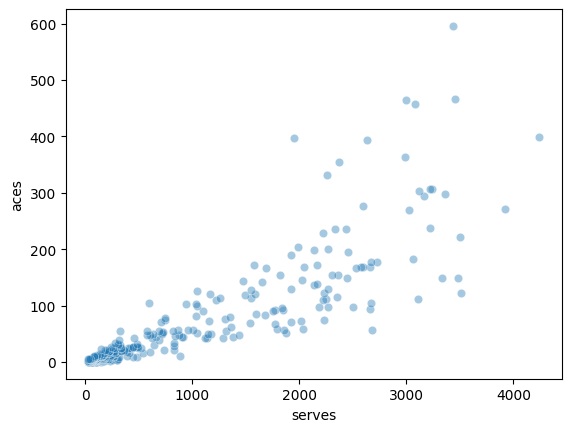

In [23]:
fig, ax = plt.subplots()

sns.scatterplot(ace_percentages, x='serves', y='aces', alpha=.4);

Text(0.5, 1.0, 'Ace Percentage of Players with over 1000 Serves (40 player random sample)')

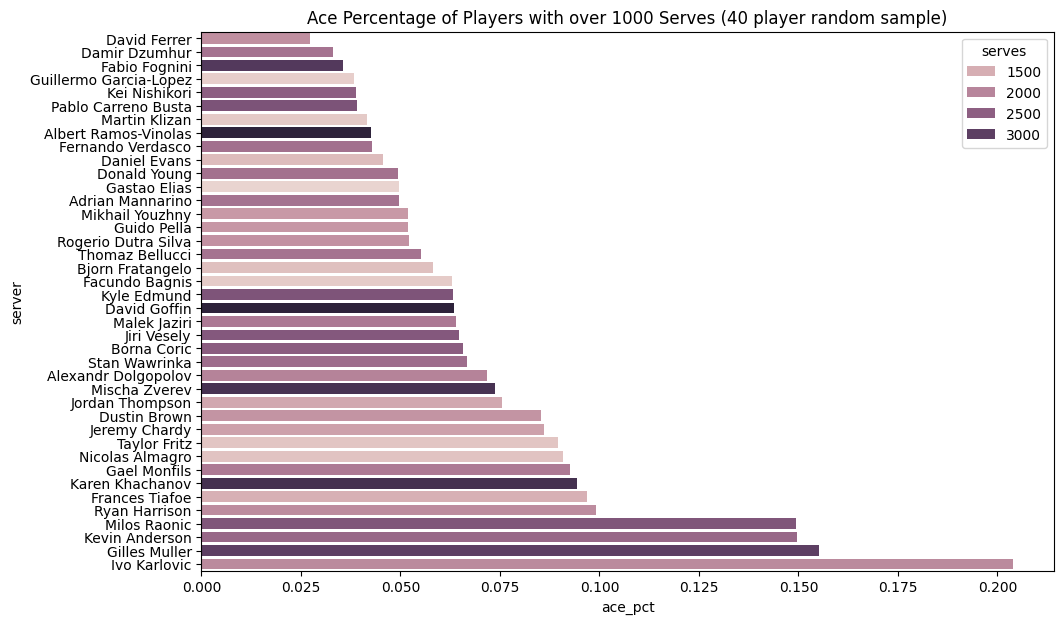

In [24]:
fig, ax = plt.subplots(figsize=(11, 7))

sns.barplot(
    ace_percentages.filter(pl.col('serves') > 1000).sample(40).sort('ace_pct'),
    x='ace_pct',
    y='server',
    hue='serves',
    ax=ax
)

ax.set_title('Ace Percentage of Players with over 1000 Serves (40 player random sample)')

### Aces by Score Situtation

Grouping by point or game situation we can clearly see the average serving strategy for players. When the server has a lead in points or games the server tends to be more aggressive with their serves leading to a higher ace percentage.

In [25]:
ace_pct_by_game = (
    train_matches
    .group_by('points_server', 'points_returner')
    .agg(
        pl.len().alias('serves'),
        pl.col('ace').sum().alias('aces'),
        pl.col('ace').mean().alias('ace_pct')
    )
    .filter(pl.col('serves') > 1_000)
    .select(
        pl.concat_str(
            pl.col('points_server'),
            pl.col('points_returner'),
            separator='-'
        ).alias('score'),
        pl.all()
    )
    .sort('ace_pct', descending=True)
)
ace_pct_by_game.head()

score,points_server,points_returner,serves,aces,ace_pct
str,i64,i64,u32,i64,f64
"""40-0""",40,0,11957,1415,0.118341
"""30-0""",30,0,17809,1873,0.105172
"""40-15""",40,15,15773,1541,0.097699
"""15-15""",15,15,20104,1492,0.074214
"""30-15""",30,15,18610,1355,0.07281


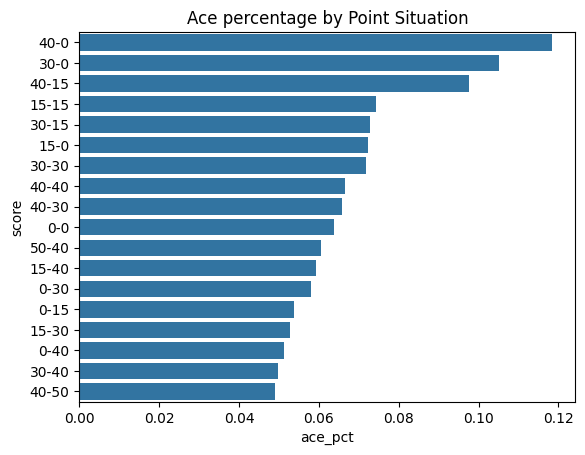

In [26]:
fig, ax = plt.subplots()

sns.barplot(ace_pct_by_game, y='score', x='ace_pct', ax=ax, orient='horizontal')

ax.set_title('Ace percentage by Point Situation');

In [27]:
ace_pct_by_set= (
    train_matches
    .group_by('games_server', 'games_returner')
    .agg(
        pl.len().alias('serves'),
        pl.col('ace').sum().alias('aces'),
        pl.col('ace').mean().alias('ace_pct')
    )
    .filter(pl.col('serves') > 1_000)
    .select(
        pl.concat_str(
            pl.col('games_server'),
            pl.col('games_returner'),
            separator='-'
        ).alias('score'),
        pl.all()
    )
    .sort('ace_pct', descending=True)
)
ace_pct_by_set.head()

score,games_server,games_returner,serves,aces,ace_pct
str,i64,i64,u32,i64,f64
"""5-1""",5,1,1753,184,0.104963
"""3-0""",3,0,1407,130,0.092395
"""5-2""",5,2,3072,278,0.090495
"""5-3""",5,3,5818,487,0.083706
"""3-1""",3,1,5784,478,0.082642


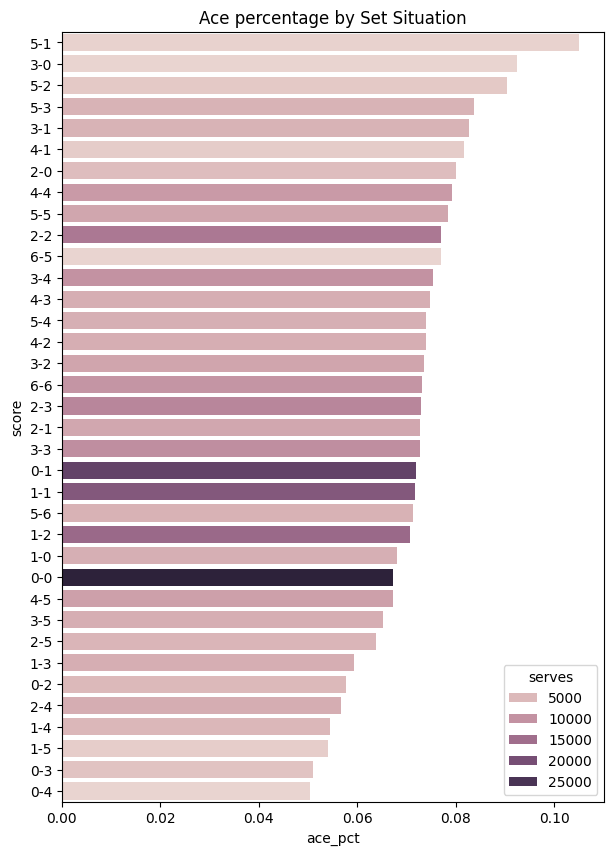

In [28]:
fig, ax = plt.subplots(figsize=(7, 10))

sns.barplot(ace_pct_by_set, y='score', x='ace_pct', ax=ax, orient='horizontal', hue='serves')
ax.set_title('Ace percentage by Set Situation');

### Height vs Ace Percentage

The scatter plot of height vs ace percentage shows a clear trend: as height increases ace percentage significantly

In [29]:
height_ace = (
    train_matches
    .group_by('height_cm_server')
    .agg(
        pl.col('ace').mean(),
        pl.len().alias('serves')
    )
)

height_ace.head()

height_cm_server,ace,serves
i64,f64,u32
198,0.104168,20899
191,0.075709,28187
203,0.128652,3560
208,0.173407,3437
178,0.0466875,16000


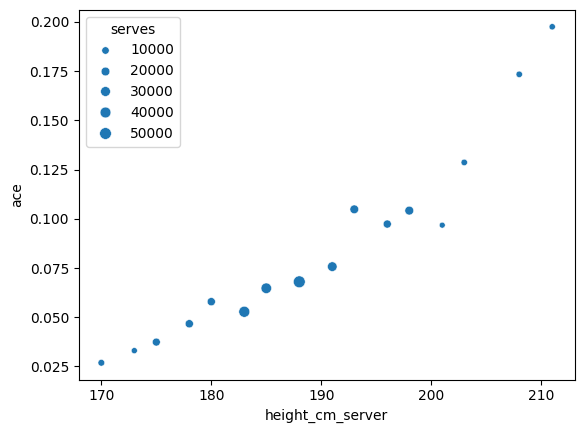

In [30]:
fig, ax = plt.subplots()

sns.scatterplot(height_ace, x='height_cm_server', y='ace', size='serves');

### Point Number vs Ace Percentage

There doesn't seem to be an obvious relationship between the number of points into the game and changes in ace percentage. Only when we get into the extreamly long games where there is very little data do we see the variance jump up and give less reliable information. Restricting the graph to just the first 250 points, we see a fairly steady ace percentage of ~7%

In [31]:
pnt_num = (
    train_matches
    .group_by('point_number')
    .agg(
        pl.col('ace').mean(),
        pl.len().alias('serves')
    )
    .sort('point_number')
)

pnt_num.head()

point_number,ace,serves
i64,f64,u32
1,0.008149,1718
2,0.075669,1718
3,0.094296,1718
4,0.0844,1718
5,0.080908,1718


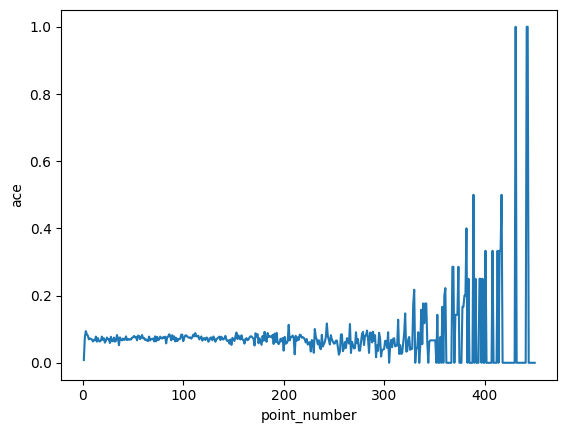

In [32]:
fig, ax = plt.subplots()

sns.lineplot(pnt_num, x='point_number', y='ace');

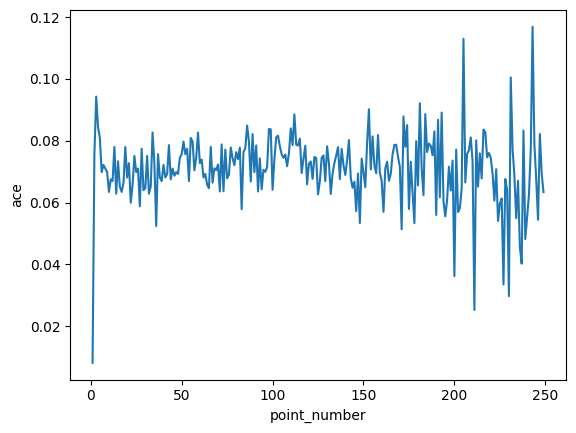

In [33]:
fig, ax = plt.subplots()

sns.lineplot(pnt_num.filter(pl.col('point_number') < 250), x='point_number', y='ace');

### Ace by Previous Point Outcome

If the server had served and ace the previous point the probability of serving an Ace increases dramatically from 6.8% to 11.1%

On the other side of the coin, if the previous point was a double fault there is a slight decrease in the probability of an Ace

In [35]:
train_matches

point_number,server,ace,double_fault,match_id,tournament,date,returner,year_turned_pro_server,height_cm_server,weight_kg_server,strong_hand_server,backhand_type_server,year_turned_pro_returner,height_cm_returner,weight_kg_returner,strong_hand_returner,backhand_type_returner,points_server,points_returner,games_server,games_returner,sets_server,sets_returner,prev_ace,prev_double_fault,datetime,current_aces,current_serves,current_ace_pct
i64,str,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,date,i64,u32,f64
1,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",0,0,0,0,0,0,0,0,2017-01-01,0,1,0.0
2,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",15,0,0,0,0,0,0,0,2017-01-01,0,2,0.0
3,"""Elias Ymer""",0,1,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,0,0,0,0,0,0,0,2017-01-01,0,3,0.0
4,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",30,15,0,0,0,0,0,1,2017-01-01,0,4,0.0
5,"""Elias Ymer""",0,0,1,"""ATPBrisbane-BrisbaneInternational""","""01 Jan 17""","""Jordan Thompson""",2014,185,78,"""Right-Handed""","""Two-Handed Backhand""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",40,15,0,0,0,0,0,0,2017-01-01,0,5,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
188,"""Tomas Berdych""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Ryan Harrison""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",3,3,6,6,2,0,0,0,2017-08-30,294,3159,0.093067
189,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,4,6,6,0,2,0,0,2017-08-30,190,1917,0.099113
190,"""Ryan Harrison""",0,0,2147,"""Men'sUSOpen""","""30 Aug 17""","""Tomas Berdych""",2007,185,84,"""Right-Handed""","""Two-Handed Backhand""",2002,196,91,"""Right-Handed""","""Two-Handed Backhand""",3,5,6,6,0,2,0,0,2017-08-30,190,1918,0.099062


In [36]:
train_matches.group_by('prev_ace').agg(
    pl.col('ace').mean().round(3).alias('ace_pct'),
    pl.len().alias('serves')
)

prev_ace,ace_pct,serves
i64,f64,u32
0,0.068,262108
1,0.111,19847


In [37]:
train_matches.group_by('prev_double_fault').agg(
    pl.col('ace').mean().round(3).alias('ace_pct'),
    pl.len().alias('serves')
)

prev_double_fault,ace_pct,serves
i64,f64,u32
0,0.072,271715
1,0.066,10240


# Model Selection

## Create validation set

Here I create another hold out set so we can do hyperparameter and model selection.

In [38]:
from sklearn.model_selection import train_test_split

X = train_matches.drop(['ace', 'match_id'])

y = train_matches['ace']

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Create Pipeline Preprocessing steps

I used to steer away from using the sklearn pipelines in previous years because it had very poor error messages and ability to troubleshoot errors which led to a frustrating user experience. Recently though they have made a lot of great changes to the usability of pipelines.

In the preprocessing pipeline I take the categorical features and impute and missing values with a "missing" string to indicate that no info is available. I can also consider replacing it with the most common element in the category but I haven't found that method to improve most models in practice. For the numeric columns I imputed missing values with the mean but also added in an indicator variable that shows when a value has been imputed. Finally, scaled the values to have a mean of 0 and a std of 1. Scaling the data like this is useful for certain models like logistic regression and others which assume a similar scale of data for each feature. Tree based models make no assumption about the

In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, log_loss, roc_auc_score

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant",
            SimpleImputer(fill_value="missing", strategy="constant"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)), #dense output required for hist_gradient boosting model
    ]
)

numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)),
        ("scaler", StandardScaler()),
    ]
)

categorical_cols = [
    "tournament",
    'server',
    'returner',
    "strong_hand_server",
    "backhand_type_server",
    "strong_hand_returner",
    "backhand_type_returner",
    'points_server',
    'points_returner',
    'games_server',
    'games_returner',
    'sets_server',
    'sets_returner',
]

numeric_cols = [
    'point_number',
    'year_turned_pro_server',
    'height_cm_server',
    'weight_kg_server',
    'year_turned_pro_returner',
    'height_cm_returner',
    'weight_kg_returner',
    'prev_ace',
    'prev_double_fault',
    'current_aces',
    'current_serves',
    'current_ace_pct'
]


preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, categorical_cols),
        ("numerical", numeric_preprocessor, numeric_cols),
    ]
)
preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputation_constant',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['tournament', 'server', 'returner',
                                  'strong_hand_server', 'backhand_type_server',
                                  'strong_hand_returner',
                                  'backhand_type_returner', 'points_s...
                                  'sets_returner']),
                                ('numerical',
                                 Pipeline(steps=[('imputation_mean',
                                                  SimpleImputer(add_indicator=True)),
                                                 ('scaler', StandardScaler())]),
                                 ['point_number', 'year_turned_pro_server',
                                  'height_cm_server', 'weight_kg_server',
                                  'year_turned_pro_returner',
                                  'height_cm_returner', 'weight_kg_returner',
                                  'prev_ace', 'prev_double_fault',
                                  'current_aces', 'current_serves',
                                  'current_ace_pct'])])

### Logistic Regression

Logistic regression is a standard method for doing binary classification since it is quick to train and understand the coefficients for interpretability.

I don't often just use logistic regression since all interaction terms must be manually created, whereas tree based models can pick up on interactions between features out of the box.

In [66]:
X_train

point_number,server,double_fault,tournament,date,returner,year_turned_pro_server,height_cm_server,weight_kg_server,strong_hand_server,backhand_type_server,year_turned_pro_returner,height_cm_returner,weight_kg_returner,strong_hand_returner,backhand_type_returner,points_server,points_returner,games_server,games_returner,sets_server,sets_returner,prev_ace,prev_double_fault,datetime,current_aces,current_serves,current_ace_pct
i64,str,i64,str,str,str,i64,i64,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,date,i64,u32,f64
169,"""Jeremy Chardy""",0,"""ATPStuttgart-MercedesCup""","""13 Jun 17""","""Florian Mayer""",2005,188,75,"""Right-Handed""","""Two-Handed Backhand""",2001,191,82,"""Right-Handed""","""Two-Handed Backhand""",15,0,1,1,1,1,0,0,2017-06-13,109,1354,0.080502
127,"""Joao Sousa""",0,"""DavisCup""","""09 Apr 17""","""Artem Smirnov""",2008,185,74,"""Right-Handed""","""Two-Handed Backhand""",null,188,85,"""Left-Handed""","""Two-Handed Backhand""",0,15,4,3,1,0,0,0,2017-04-09,41,1028,0.039883
210,"""Thiago Monteiro""",0,"""Gentlemen'sWimbledonSingles""","""05 Jul 17""","""Karen Khachanov""",2011,183,78,"""Left-Handed""","""Two-Handed Backhand""",2013,198,87,"""Right-Handed""","""Two-Handed Backhand""",15,0,5,6,1,1,0,0,2017-07-05,56,1191,0.047019
143,"""Benoit Paire""",0,"""ATPUmag-PlavaLagunaCroatiaOpen""","""18 Jul 17""","""Kenny De Schepper""",2007,196,80,"""Right-Handed""","""Two-Handed Backhand""",2010,203,100,"""Left-Handed""","""One-Handed Backhand""",0,0,0,2,1,1,0,0,2017-07-18,218,2533,0.086064
38,"""Malek Jaziri""",0,"""Gentlemen'sWimbledonSingles""","""03 Jul 17""","""Lucas Pouille""",2003,185,83,"""Right-Handed""","""Two-Handed Backhand""",2012,185,84,"""Right-Handed""","""Two-Handed Backhand""",0,0,3,4,0,0,0,0,2017-07-03,97,1495,0.064883
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
158,"""Roberto Bautista Agut""",0,"""ATPBarcelona-BarcelonaOpenBancSabadell""","""27 Apr 17""","""Albert Ramos-Vinolas""",2005,183,75,"""Right-Handed""","""Two-Handed Backhand""",2007,188,76,"""Left-Handed""","""Two-Handed Backhand""",30,30,4,5,1,1,0,0,2017-04-27,46,1432,0.032123
65,"""Jeremy Chardy""",0,"""Men'sUSOpen""","""30 Aug 17""","""Gael Monfils""",2005,188,75,"""Right-Handed""","""Two-Handed Backhand""",2004,193,85,"""Right-Handed""","""Two-Handed Backhand""",40,30,5,6,0,0,0,0,2017-08-30,142,1578,0.089987
124,"""Jordan Thompson""",0,"""DavisCup""","""03 Feb 17""","""Jiri Vesely""",2013,183,82,"""Right-Handed""","""Two-Handed Backhand""",2009,198,94,"""Left-Handed""","""Two-Handed Backhand""",40,40,0,1,2,0,0,0,2017-02-03,35,407,0.085995


In [67]:
logistic = make_pipeline(preprocessor, LogisticRegression(max_iter=500, C=.01))

In [68]:
logistic.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['tournament', 'server',
                                                   'returner',
                                                   'strong_hand_server',
                                                   'backhand_type_server',
                                                   'strong_hand_returne...
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['point_number',
                                                   'year_turned_pro_server',
                                                   'height_cm_server',
                                                   'weight_kg_server',
                                                   'year_turned_pro_returner',
                                                   'height_cm_returner',
                                                   'weight_kg_returner',
                                                   'prev_ace',
                                                   'prev_double_fault',
                                                   'current_aces',
                                                   'current_serves',
                                                   'current_ace_pct'])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=500))])

In [69]:
logistic_probs = logistic.predict_proba(X_test)

logistic_predictions = logistic.predict(X_test)

In [71]:
logistic_coef = pl.DataFrame({
    'feature':logistic.named_steps['columntransformer'].get_feature_names_out(),
    'coefficient': logistic.named_steps['logisticregression'].coef_[0].tolist()
}).sort(by='coefficient')

logistic_coef

feature,coefficient
str,f64
"""categorical__tournament_ATPMonte-Carlo-Monte-CarloRolexMasters""",-0.297666
"""categorical__tournament_ATPUmag-PlavaLagunaCroatiaOpen""",-0.287022
"""categorical__points_returner_50""",-0.274498
"""categorical__tournament_ATPMarrakech-GrandPrixHassanII""",-0.26753
"""categorical__returner_Gael Monfils""",-0.266661
…,…
"""categorical__server_Feliciano Lopez""",0.250532
"""categorical__returner_Paul-Henri Mathieu""",0.287935
"""categorical__tournament_ATPStuttgart-MercedesCup""",0.311032


#### Points features Coefficients

The highest magnitude negative coefficients are when the returner has advantage or has a high points. We can interpret this as saying when the returner is most likely to have and advantage in points the probability of an ace goes down. This confirms our analysis of point situations that we conducted earlier.

The highest magnitude positive coefficients are the inverse. When the server is most likely to have an advantage, as in when the returner has 0 points, we see the highest increase in probability of a serve

In [80]:
logistic_coef.filter(pl.col('feature').str.contains('points')).sort(by='coefficient')

feature,coefficient
str,f64
"""categorical__points_returner_50""",-0.274498
"""categorical__points_server_0""",-0.24487
"""categorical__points_returner_40""",-0.103965
"""categorical__points_server_15""",-0.092821
"""categorical__points_returner_6""",-0.07542
…,…
"""categorical__points_server_30""",0.080516
"""categorical__points_returner_15""",0.123206
"""categorical__points_returner_1""",0.130818


#### Numerical Coefficients

The numerical features which most strongly correlate with an increase in ace percentage are what we expected. The taller and heavier the server the higher the probability of an ace

In [73]:
logistic_coef.filter(pl.col('feature').str.contains('numeric')).sort(by='coefficient')

feature,coefficient
str,f64
"""numerical__year_turned_pro_returner""",-0.039291
"""numerical__current_serves""",-0.036037
"""numerical__missingindicator_height_cm_server""",-0.026738
"""numerical__missingindicator_weight_kg_returner""",-0.022971
"""numerical__missingindicator_year_turned_pro_returner""",-0.02278
…,…
"""numerical__prev_ace""",0.040491
"""numerical__weight_kg_server""",0.059378
"""numerical__current_aces""",0.097294


#### Previous point coeffecients

Previous point being an ace is the largest magnitude category coefficient indicating that an ace on the previous point does increase the probability of the current serve being an ace

In [74]:
logistic_coef.filter(pl.col('feature').str.contains('prev')).sort(by='coefficient')

feature,coefficient
str,f64
"""numerical__prev_double_fault""",0.000648
"""numerical__prev_ace""",0.040491


#### Cummulative Ace stats

In [75]:
logistic_coef.filter(pl.col('feature').str.contains('current')).sort(by='coefficient')

feature,coefficient
str,f64
"""numerical__current_serves""",-0.036037
"""numerical__current_aces""",0.097294
"""numerical__current_ace_pct""",0.163462


In [76]:
roc_auc_score(y_test, logistic_probs[:, 1])

np.float64(0.6664653169093241)

### HistGradientBoosting Classifier

This tree based model great first pass model since it natively handles null values and interaction terms as well as being quicker to train than alternative tree based models

In [54]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_grad = make_pipeline(preprocessor, HistGradientBoostingClassifier(learning_rate=.001, max_iter=500))

In [55]:
hist_grad.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['height_cm_server',
                                                   'prev_ace',
                                                   'prev_double_fault',
                                                   'current_aces',
                                                   'current_serves',
                                                   'current_ace_pct'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(learning_rate=0.001,
                                                max_iter=500))])

In [56]:
hist_grad_probs = hist_grad.predict_proba(X_test)

preds = hist_grad.predict(X_test)

roc_auc_score(y_test, hist_grad_probs[:, 1])

np.float64(0.6337100670789477)

### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=1_000))

rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['tournament',
                                                   'strong_hand_server',
                                                   'backhand_type_server',
                                                   'strong_hand_returner',
                                                   'backhand_type_re...
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['point_number',
                                                   'year_turned_pro_server',
                                                   'height_cm_server',
                                                   'weight_kg_server',
                                                   'year_turned_pro_returner',
                                                   'height_cm_returner',
                                                   'weight_kg_returner',
                                                   'current_aces',
                                                   'current_serves',
                                                   'current_ace_pct'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=1000))])

In [51]:
rf_probs = rf.predict_proba(X_test)

rf_preds = rf.predict(X_test)

roc_auc_score(y_test, rf_probs[:, 1])

np.float64(0.6632675036312807)

In [52]:
rf_coef = pl.DataFrame({
    'feature':rf.named_steps['columntransformer'].get_feature_names_out(),
    'fi': rf.named_steps['randomforestclassifier'].feature_importances_.tolist()
})

rf_coef.sort(by='fi')

feature,fi
str,f64
"""categorical__points_server_18""",3.2356e-9
"""categorical__points_server_13""",3.7634e-9
"""categorical__points_returner_16""",1.5215e-8
"""categorical__points_returner_14""",1.6067e-8
"""categorical__points_returner_12""",2.8581e-8
…,…
"""numerical__weight_kg_returner""",0.035316
"""numerical__current_aces""",0.0741
"""numerical__point_number""",0.096222


<Axes: xlabel='fi', ylabel='feature'>

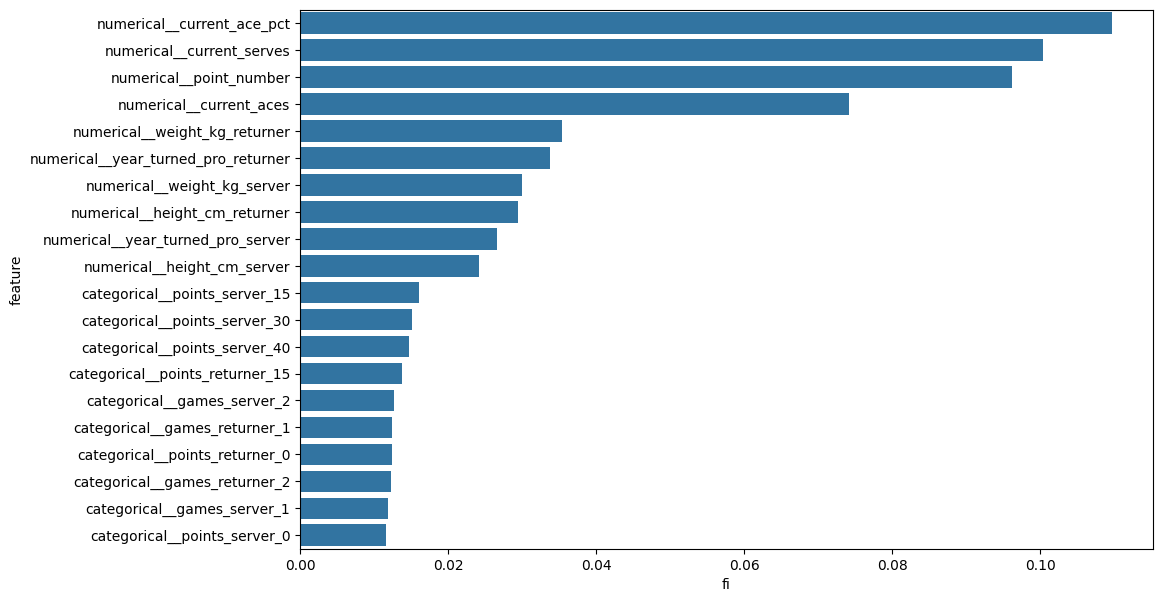

In [61]:
fig, ax = plt.subplots(figsize=(11, 7))

sns.barplot(
    rf_coef.sort(by='fi', descending=True).head(20),
    x='fi',
    y='feature',
    ax=ax,
    orient='h'
)

# ax.set_title('Ace Percentage of Players with over 1000 Serves (40 player random sample)')

### KNN

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=10))

knn.fit(X_train, y_train)

knn_probs = knn.predict_proba(X_test)

knn_preds = knn.predict(X_test)

roc_auc_score(y_test, knn_probs[:, 1])

np.float64(0.5896357521027051)

### Predicted Probability Distributions

In [ ]:
fig, ax = plt.subplots()

models = [
    ('Random Forest', rf_probs),
    ('Hist Grad', hist_grad_probs),
    ('logistic', logistic_probs),
    ('knn', knn_probs),
]

for model, probs in models:
    ax.hist(probs[:, 1], bins=50, alpha=.5, label=model)

ax.legend();

## AUROC

The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is the plot of the true positive rate (TPR) against the false positive rate (FPR) at each threshold setting. So the area under this curve (AUC) is a great metric for comparing the relative effectiveness of each model when there is a large class imbalance. A higher AUC equates to a better model.

The **Histogram Gradient Boosting Classifier** performs the best out of the chosen models with an **AUC of 0.64**

In [ ]:
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay

fig, ax = plt.subplots()

for model, probs in models:
    RocCurveDisplay.from_predictions(y_test, probs[:, 1], ax=ax, name=model)

# Test Set Metrics

Using the held out data from the begining of the analysis lets see how our best performing model does on the new data

## Feature engineering

In [ ]:
test_matches = pl.read_parquet('../data/test_matches.parquet', columns=feature_cols)

test_matches = (test_matches.with_columns(
                     pl.when(pl.col('server') == pl.col('player1'))
                     .then(pl.col('player2'))
                     .otherwise(pl.col('player1'))
                     .alias('returner')
                 ).join(
                     players.select(pl.all().name.suffix("_server")),
                     how='left',
                     left_on='server',
                     right_on='name_server',
                 ).join(
                     players.select(pl.all().name.suffix("_returner")),
                     how='left',
                     left_on='returner',
                     right_on='name_returner',
                 ))

for col in ['points', 'games', 'sets']:
    test_matches = create_score_features(test_matches, col)

test_matches = test_matches.drop([
    'points_1',
    'points_2',
    'games_1',
    'games_2',
    'sets_1',
    'sets_2',
    'player1',
    'player2'
])

test_matches = test_matches.select(
    pl.all(),
    pl.col('ace').sort_by('point_number').shift(fill_value=0).over('match_id', 'server').alias('prev_ace'),
    pl.col('double_fault').sort_by('point_number').shift(fill_value=0).over('match_id', 'server').alias('prev_double_fault')
)

test_matches = test_matches.sort(by=['match_id', 'point_number']).select(
    pl.all(),
    pl.col('ace').shift(fill_value=0).cum_sum().over('server').alias('current_aces'),
    pl.col('ace').shift(fill_value=0).cum_count().over('server').alias('current_serves'),
    (pl.col('ace').shift(fill_value=0).cum_sum().over('server') / pl.col('ace').shift(fill_value=0).cum_count().over('server')).alias('current_ace_pct'),
).sort(by=['match_id', 'point_number'])

test_matches.head()

## Use best performing model 

The histogram gradient boosting model showed the best performance in the training data with an AUC of 0.67.

Using the model fitted on the testing data to predict on the validation data held out from the begining of the analysis we see that the model achieved almost exactly the same performance. This is a good sign that we have not overfit to training data and can generalize well to future data

In [ ]:
X_val = test_matches.drop(['ace', 'match_id'])

y_val = test_matches['ace']

validation_probs = hist_grad.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, validation_probs), 4) 

In [ ]:
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(
    y_val,
    validation_probs,
    ax=ax,
    name="HistGradient Boosting Tree"
);

# Appendix

### Find optimal threshold for predicting Ace

If we wanted to turn the probabilities into hard labels then a balanced accuarcy score based off of a 50% threshold is not useful. Especially in this case where 99% of predicted probabilites are going to be less than 40%. This means that if we want to give hard predicted labels of Ace or no Ace we should find a better threshold based off another metric like roc_auc or f1 score. 

In [ ]:
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, classification_report

In [ ]:
tuned_hist_grad = TunedThresholdClassifierCV(hist_grad, scoring='roc_auc')
tuned_hist_grad.fit(X_val, y_val)

In [ ]:
tuned_hist_preds = tuned_hist_grad.predict(X_val)

In [ ]:
print(f"Best decision threshold for maximizing roc_auc: {round(float(tuned_hist_grad.best_threshold_), 4)}")

In [ ]:
print(classification_report(y_val, tuned_hist_preds))

## Calibration

Make sure that the predicted probabilities are correctly calibrated so that for each quantile of data the fraction of labels that are actually postitive matches the mean predicted probability of the model. A perfectly calibrated model would fall directly on the diagonal but in the case of the histogram gradient boosted model it strays off of the line where there is comparitively little data very few data points are actually predicted to have a probability higher than .15.



In [ ]:
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(figsize=(5, 5))

CalibrationDisplay.from_estimator(tuned_hist_grad, X_val, y_val, n_bins=20, strategy='quantile', ax=ax, label='Histogram Gradient Boosting');

# Future Work

1. **Hyper parameter tuning**: Use gridsearch to identify optimal hyperparameter for each model
2. **Model Error Analysis**: Look at where the models were most wrong with their predictions. Are there any particular situations in which the model struggles?
3. **More model interpretability**: [Shap values](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html) can be useful way to understand how each of the models use the features to make individual predictions. These insights can help better understand the weaknesses and strengths of each model type on our specific usecase
4. **More Feature engineering**: Adding some leading indicators based on previous point situations players. Features like, how many aces did this particular player serve this year so far or what is the serve percentage at this tournement so far. It is important to include the "so far" part of the features because we want to ensure that only the information that we would have available in a realtime setting is used to train the model.